In [30]:
import pandas as pd
import numpy as np
from transformers import PreTrainedTokenizerFast, BertForMaskedLM
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt


device = "mps"
data_path = "amazon_edna_test_data.tsv"
max_len = 660

torch.set_grad_enabled(False)

model = BertForMaskedLM.from_pretrained("LofiAmazon/BarcodeBERT-Entire-BOLD")
model.to(device)
model.eval()

tokenizer = PreTrainedTokenizerFast.from_pretrained("LofiAmazon/BarcodeBERT-Entire-BOLD")

df = pd.read_csv(data_path, sep="\t")

embeddings = []
for nucleotides in tqdm(df["nucraw"]):
    # Replace non ACTG characters with N
    nucleotides = "".join([nuc if nuc in "ACTG" else "N" for nuc in nucleotides])
    # Truncate to max_len
    nucleotides = nucleotides[:max_len]
    # Add spacing after every 4 characters
    nucleotides = " ".join([nucleotides[i:i+4] for i in range(0, len(nucleotides), 4)])

    # Tokenize
    inputs = tokenizer(nucleotides, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs).hidden_states[-1]
    outputs = outputs.mean(1).squeeze().cpu().numpy()

    embeddings.append(outputs)

df["embedding"] = embeddings

100%|██████████| 933/933 [00:21<00:00, 43.35it/s]


In [65]:
from pinecone import Pinecone

pc = Pinecone(api_key="REPLACE WITH YOUR API KEY")
index = pc.Index("amazon")

top_k = []
for embedding in tqdm(df["embedding"]):
    # Look for the nearest neighbor
    result = index.query(
        namespace="all",
        vector=embedding.tolist(),
        top_k=100,
        include_metadata=True,
    )
    top_k.append([m["metadata"]["genus"] for m in result["matches"]])

top_genus = []
for embedding in tqdm(df["embedding"]):
    # Look for the nearest neighbor
    result = index.query(
        namespace="by_genus",
        vector=embedding.tolist(),
        top_k=1,
        include_metadata=True,
    )
    top_genus = result["matches"][0]["id"]

df["top_k"] = top_k
df["top_genus"] = top_genus

100%|██████████| 10/10 [00:01<00:00,  7.56it/s]


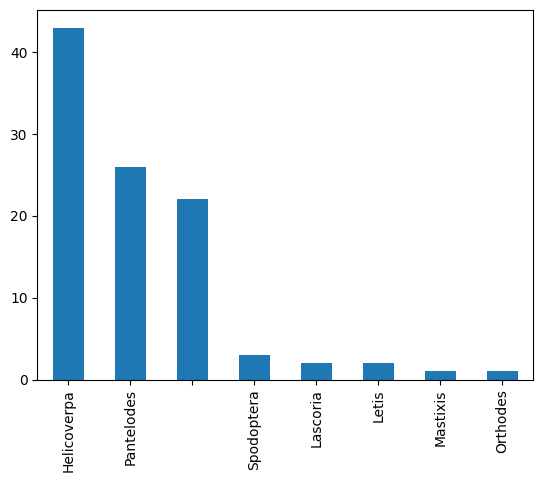

'Paraba'

In [63]:
idx = 7

# Grab the top_k cell of the first row
top_k = df["top_k"].iloc[idx]
# Count the number of times each genus appears
top_k = pd.Series(top_k).value_counts()
# Plot
top_k.plot(kind="bar")

plt.show()

df["top_genus"].iloc[idx]